# **Image Classification with Convolutional Neural Networks (CNNs)**





# **Building a Convolutional Neural Network with Keras**

**Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
tf.__version__

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import imageio

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

'2.8.2'

**Memory Utilization Checkup (Before/After Model Execution)**

In [ ]:
#CPU AND GPU LIBRARIES INSTALLATION (if you find error on import of psutil and GPUtil, please refer below)
!pip install psutil
!pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=f41c3354aa64dc7521ad9786ec65f356a8194b9338ce1ecca32f161dcf013c0c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [ ]:
# CHECKING THE CPU AND GPU MEMORY

# Testing the psutil library for both CPU and RAM performance details
print(psutil.cpu_percent())
print(psutil.sys.ram)
print(psutil.virtual_memory().percent)
# Testing the GPUtil library for both GPU performance details
GPUtil.showUtilization()

In [ ]:
#CPU MEMORY UTILIZATION

!cat /proc/meminfo

MemTotal:       13298572 kB
MemFree:         3426352 kB
MemAvailable:   10348672 kB
Buffers:          130260 kB
Cached:          5873676 kB
SwapCached:            0 kB
Active:          3185400 kB
Inactive:        6177368 kB
Active(anon):    2329176 kB
Inactive(anon):    14792 kB
Active(file):     856224 kB
Inactive(file):  6162576 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               248 kB
Writeback:             0 kB
AnonPages:       3358868 kB
Mapped:          1712792 kB
Shmem:             15548 kB
KReclaimable:     229572 kB
Slab:             295072 kB
SReclaimable:     229572 kB
SUnreclaim:        65500 kB
KernelStack:        5312 kB
PageTables:        24120 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649284 kB
Committed_AS:    5873988 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       51372 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13298572 kB


In [ ]:
#GPU MEMORY UTILIZATION 
!nvidia-smi --query-gpu=memory.total --format=csv

memory.total [MiB]
15109 MiB


In [ ]:
# Function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 10.6 GB
GPU 0 ... Mem Free: 10421MB / 15109MB | Utilization  31%


## **Let's Start with Model Implementation**

**Data Acquisition and ImageDataGenerator**


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#File path to the folder containin images
train_dir = os.path.join('/content/dataset-colab/Train')
validation_dir = os.path.join('/content/dataset-colab/Test')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

Found 33128 images belonging to 2 classes.
Found 6780 images belonging to 2 classes.


**Building the Model**

In [ ]:
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Second convolution layer 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    

    # Third convolution layer 
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Fourth convolution layer  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(8, activation='relu',use_bias=True),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid',activity_regularizer=regularizers.L1(0.001))   

])


**Printing Model Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       2

**Optimizer Implementation and model training/validation**

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)])  

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99): 
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=500,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=5, 
      callbacks = [callbacks,checkpoint]
) 

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5004 - sensitivity_at_specificity: 0.4652 - specificity_at_sensitivity: 0.4637 - recall: 0.3439 - precision: 0.5086
Epoch 1: val_accuracy improved from -inf to 0.50313, saving model to ECG_Spectrogram_Model.h5
10/10 [==============================] - 18s 237ms/step - loss: 0.6997 - accuracy: 0.5004 - sensitivity_at_specificity: 0.4652 - specificity_at_sensitivity: 0.4637 - recall: 0.3439 - precision: 0.5086 - val_loss: 0.6936 - val_accuracy: 0.5031 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_recall: 1.0000 - val_precision: 0.5031
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5277 - sensitivity_at_specificity: 0.0406 - specificity_at_sensitivity: 0.0772 - recall: 0.9077 - precision: 0.5315
Epoch 2: val_accuracy did not improve from 0.50313
10/10 [==============================] - 2s 164ms/step - loss: 0.

**Performance Metrics**

In [ ]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",max(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

Training Accuracy:  0.9789062738418579
Validation Accuracy:  0.9906250238418579
Validation Specificity:  1.0
Validation Sensitivity:  1.0
Validation Recall:  1.0
Validation Precision:  0.9983713626861572
Validation Loss:  0.04193344712257385


**Accuracy Graph**

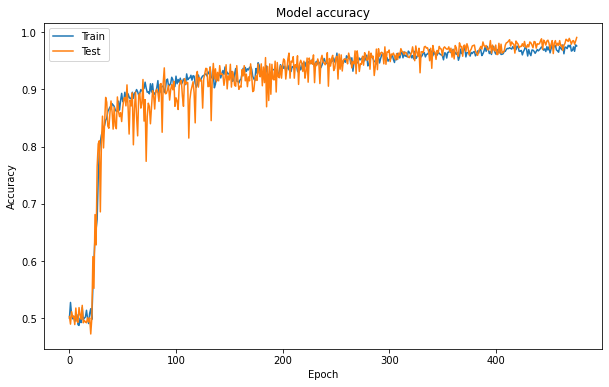

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Loss Graph**

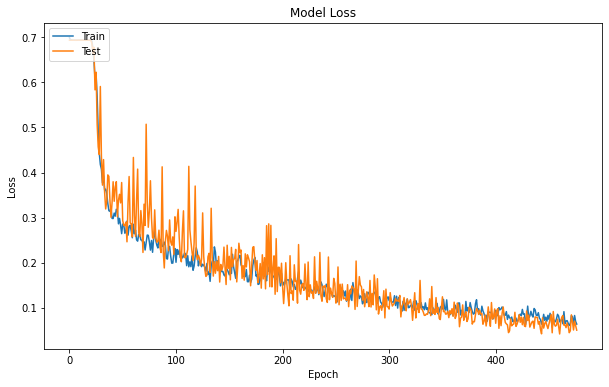

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()